In [1]:
import numpy
import matplotlib.pyplot as plt
from PIL import Image
import sklearn
import xgboost as xgb

In [2]:
def _split_mat(arr: numpy.ndarray, blk_size: int = 16):
    l = numpy.split(arr, list(range(blk_size,arr.shape[0],blk_size)))
    split = []
    for x in l:
        tmp = numpy.split(x, list(range(blk_size,arr.shape[0],blk_size)), axis=1)
        for y in tmp:
            split.append(y)
    return split
# bin(4)
def get_ubins():
    bins = []
    for i in range(256):
        bin_form = bin(i)
        bin_form = bin_form[2:]
        trns = 0
        #while len(bin_form) <= 8:
         #  bin_form = '0' + bin_form
        curr = bin_form[0]
        prev = bin_form[0]
        for x in bin_form:
            prev = curr
            curr = x
            if curr != prev:
                trns +=1
        if trns <= 2:
            bins.append(i)
    return bins

bins = get_ubins()

def _lbph_algorithm(path: str, ubins: list):
    im = Image.open(path).convert("L")
    im = numpy.array(im)
    min_indx = 0
    max_indx = im.shape[0]
    im.setflags(write=True)

    for i in range(max_indx):
        for j in range(max_indx):

            lbp = ''

            if (i-1) > min_indx and (j-1) > min_indx:
                if im[i][j] >= im[i-1][j-1]:
                    lbp += '0'
                else:
                    lbp += '1'

            if (i-1) > min_indx and (j) < max_indx:
                if im[i][j] >= im[i-1][j]:
                    lbp += '0'
                else:
                    lbp += '1'

            if (i-1) > min_indx and (j+1) < max_indx:
                if im[i][j] >= im[i-1][j+1]:
                    lbp += '0'
                else:
                    lbp += '1'

            if (i) < max_indx and (j+1) < max_indx:
                if im[i][j] >= im[i][j+1]:
                    lbp += '0'
                else:
                    lbp += '1'

            if (i+1) < max_indx and (j+1) < max_indx:
                if im[i][j] >= im[i+1][j+1]:
                    lbp += '0'
                else:
                    lbp += '1'

            if (i+1) < max_indx and (j) < max_indx:
                if im[i][j] >= im[i+1][j]:
                    lbp += '0'
                else:
                    lbp += '1'

            if (i+1) < max_indx and (j-1) > min_indx:
                if im[i][j] >= im[i+1][j-1]:
                    lbp += '0'
                else:
                    lbp += '1'

            if (i) < max_indx and (j-1) > min_indx:
                if im[i][j] >= im[i][j-1]:
                    lbp += '0'
                else:
                    lbp += '1'

            im[i][j] = int(lbp,2)

    tiles = []

    tiles = _split_mat(im)

    hist = []

    for tile in tiles:
        o = numpy.histogram(tile, ubins)
        hist.append(o[0])

    hist = numpy.concatenate(hist)

    return im , hist

In [3]:
import numpy as np
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [4]:
!cp /content/drive/MyDrive/ColabData/FacialExpressionData/data.zip /content/data.zip

In [5]:
!rm -rf /content/savs

In [6]:
import zipfile
import os

current_dir = os.getcwd()

data_zip = current_dir + "/data.zip"
data_path = current_dir + "/data"

isColab = True

if isColab:
    os.mkdir(current_dir + "/savs")
    with zipfile.ZipFile(data_zip,"r") as zip:
        zip.extractall(data_path)

In [7]:
!file data/train/angry/0.jpg | grep -Eo "[[:digit:]]+ *x *[[:digit:]]+"

1x1
48x48


In [8]:
image_size = (48, 48)
batch_size = 128
import keras
from keras import layers
from tensorflow import data as tf_data
import matplotlib.pyplot as plt

train_ds, val_ds = keras.utils.image_dataset_from_directory(
    "data/train/",
    validation_split=0.2,
    subset="both",
    seed=1337,
    image_size=image_size,
    batch_size=batch_size,
)

Found 28821 files belonging to 7 classes.
Using 23057 files for training.
Using 5764 files for validation.


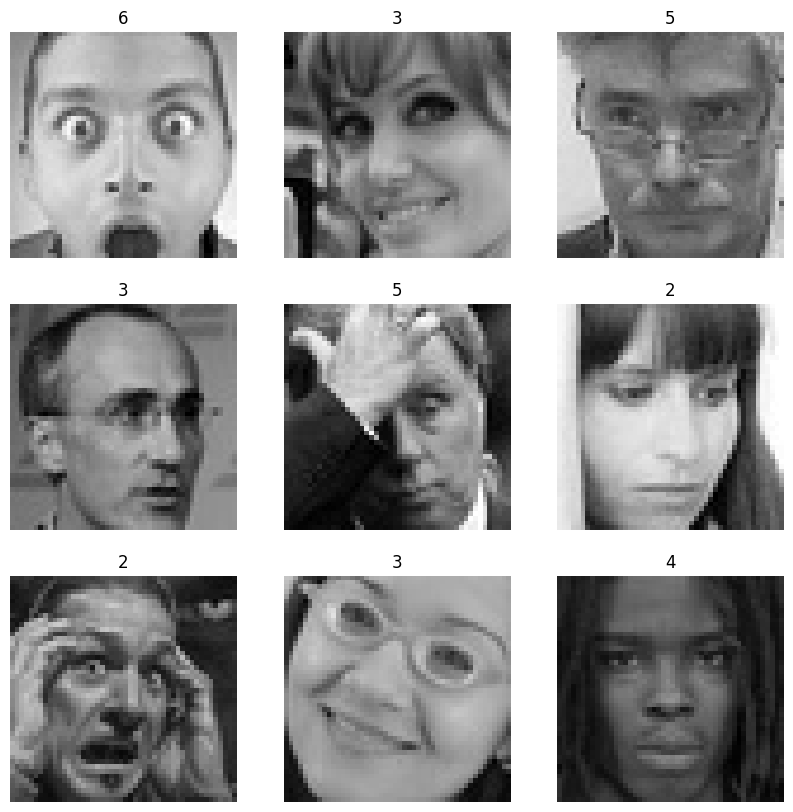

In [9]:
plt.figure(figsize=(10, 10))
for images, labels in train_ds.take(1):
    for i in range(9):
        ax = plt.subplot(3, 3, i + 1)
        plt.imshow(np.array(images[i]).astype("uint8"))
        plt.title(int(labels[i]))
        plt.axis("off")

In [10]:
import keras
from keras import layers
from tensorflow import data as tf_data
import matplotlib.pyplot as plt


def make_model(input_shape, num_classes):
    inputs = keras.Input(shape=input_shape)

    # Entry block
    x = layers.Rescaling(1.0 / 255)(inputs)
    x = layers.Conv2D(128, 3, strides=2, padding="same")(x)
    x = layers.BatchNormalization()(x)
    x = layers.Activation("relu")(x)

    previous_block_activation = x  # Set aside residual

    for size in [256, 512, 728]:
        x = layers.Activation("relu")(x)
        x = layers.SeparableConv2D(size, 3, padding="same")(x)
        x = layers.BatchNormalization()(x)

        x = layers.Activation("relu")(x)
        x = layers.SeparableConv2D(size, 3, padding="same")(x)
        x = layers.BatchNormalization()(x)

        x = layers.MaxPooling2D(3, strides=2, padding="same")(x)

        # Project residual
        residual = layers.Conv2D(size, 1, strides=2, padding="same")(
            previous_block_activation
        )
        x = layers.add([x, residual])  # Add back residual
        previous_block_activation = x  # Set aside next residual

    x = layers.SeparableConv2D(1024, 3, padding="same")(x)
    x = layers.BatchNormalization()(x)
    x = layers.Activation("relu")(x)

    x = layers.GlobalAveragePooling2D()(x)
    if num_classes == 2:
        units = 1
    else:
        units = 7
    x = layers.Flatten()(x)
    x = layers.Dropout(0.25)(x)
    # We specify activation=None so as to return logits
    outputs = layers.Dense(units, activation="softmax")(x)
    return keras.Model(inputs, outputs)


model = make_model(input_shape=image_size + (3,), num_classes=7)


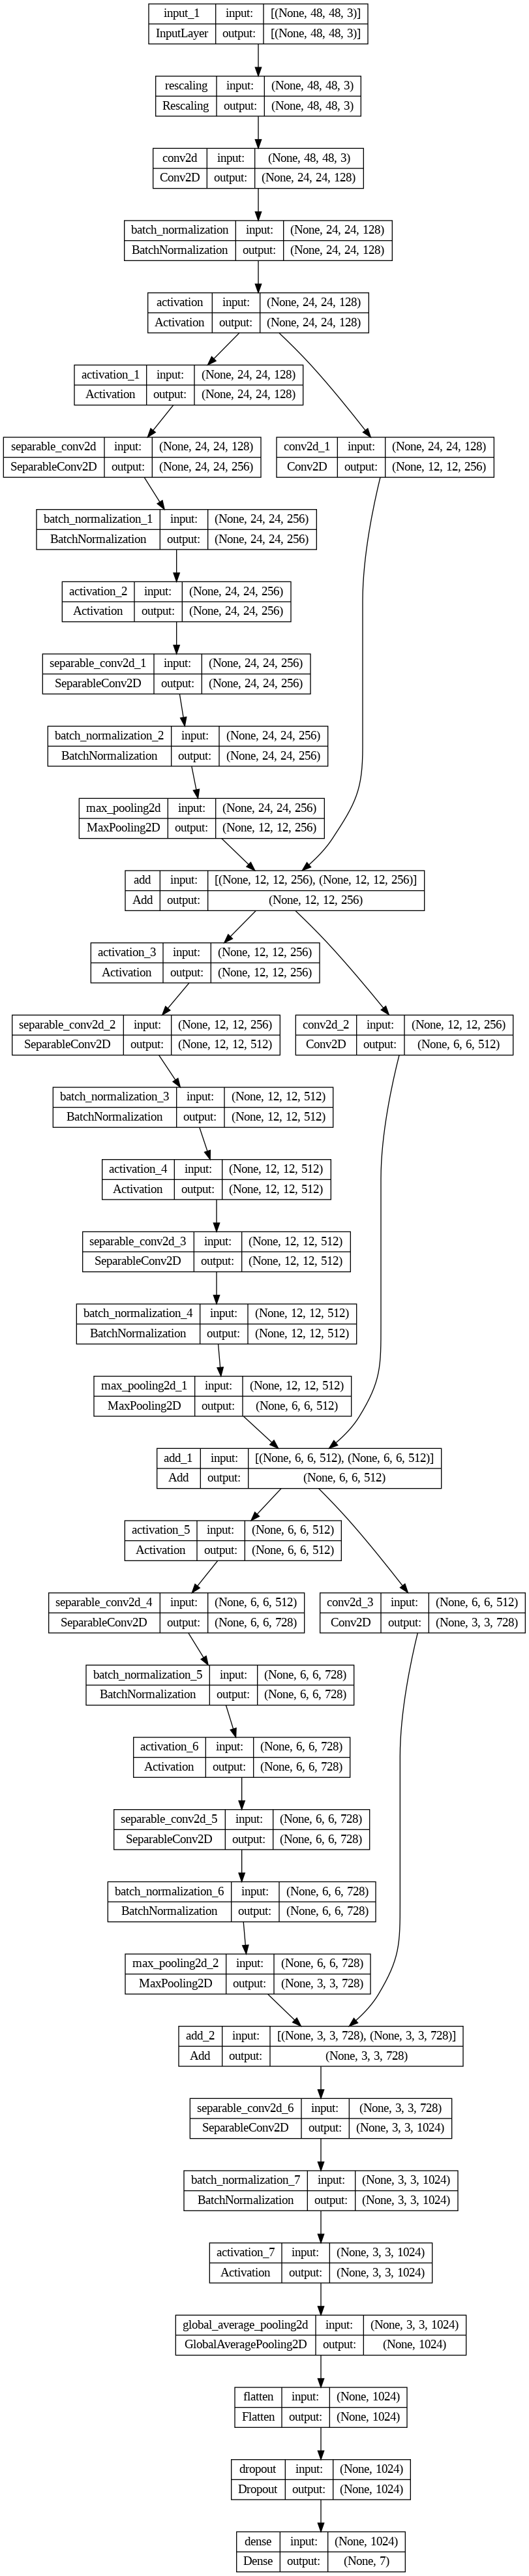

In [11]:
keras.utils.plot_model(model, show_shapes=True)

In [12]:
data_augmentation_layers = [
    layers.RandomFlip("horizontal"),
    layers.RandomRotation(0.1),
]


def data_augmentation(images):
    for layer in data_augmentation_layers:
        images = layer(images)
    return images

train_ds = train_ds.map(
    lambda img, label: (data_augmentation(img), label),
    num_parallel_calls=tf_data.AUTOTUNE,
)
# Prefetching samples in GPU memory helps maximize GPU utilization.
train_ds = train_ds.prefetch(tf_data.AUTOTUNE)
val_ds = val_ds.prefetch(tf_data.AUTOTUNE)

In [14]:
import tensorflow as tf
device_name = tf.test.gpu_device_name()
if device_name != '/device:GPU:0':
  raise SystemError('GPU device not found')
print('Found GPU at: {}'.format(device_name))

Found GPU at: /device:GPU:0


In [18]:
epochs = 100

callbacks = [
    keras.callbacks.ModelCheckpoint("save_at_{epoch}.keras"),
]

model.compile(loss=keras.losses.SparseCategoricalCrossentropy(), optimizer="adam", metrics=["accuracy"])

from keras.models import load_model
model = load_model("/content/save_at_59.keras")

with tf.device('/device:GPU:0'):
  model.fit(
    train_ds,
    epochs=epochs,
    callbacks=callbacks,
    validation_data=val_ds,
    initial_epoch=59,
  )


Epoch 60/100
181/181 [==============================] - 21s 107ms/step - loss: 0.4434 - accuracy: 0.8398 - val_loss: 1.4975 - val_accuracy: 0.5911
Epoch 61/100
181/181 [==============================] - 20s 109ms/step - loss: 0.4176 - accuracy: 0.8482 - val_loss: 1.5475 - val_accuracy: 0.5985
Epoch 62/100
181/181 [==============================] - 19s 105ms/step - loss: 0.4076 - accuracy: 0.8514 - val_loss: 1.4965 - val_accuracy: 0.5989
Epoch 63/100
181/181 [==============================] - 20s 108ms/step - loss: 0.4006 - accuracy: 0.8544 - val_loss: 1.5520 - val_accuracy: 0.5880
Epoch 64/100
181/181 [==============================] - 19s 106ms/step - loss: 0.3870 - accuracy: 0.8627 - val_loss: 1.5983 - val_accuracy: 0.6195
Epoch 65/100
181/181 [==============================] - 19s 105ms/step - loss: 0.3913 - accuracy: 0.8591 - val_loss: 1.5427 - val_accuracy: 0.6145
Epoch 66/100
181/181 [==============================] - 19s 105ms/step - loss: 0.3737 - accuracy: 0.8637 - val_loss: 1

In [20]:
!ls data/validation

angry  disgust	fear  happy  neutral  sad  surprise


In [77]:
test_ds, _ds = keras.utils.image_dataset_from_directory(
    "data/validation/",
    validation_split=0.01,
    subset="both",
    seed=1337,
    image_size=image_size,
    batch_size=batch_size,
)

Found 7066 files belonging to 7 classes.
Using 6996 files for training.
Using 70 files for validation.


In [82]:
predictions = []
labels = []

for x,y in test_ds:
  y_t = model.predict(x)
  for i in range(x.shape[0]):
    predictions.append(int(np.argmax(y_t[i])))
    labels.append(int(y[i]))

3/3 [==============================] - 0s 10ms/step


In [83]:
print(labels)

[6, 6, 5, 4, 3, 4, 6, 3, 0, 3, 4, 5, 6, 6, 6, 4, 4, 5, 5, 4, 3, 6, 3, 0, 2, 4, 5, 0, 3, 4, 3, 5, 5, 4, 6, 4, 4, 4, 2, 4, 2, 2, 5, 6, 3, 0, 5, 4, 3, 0, 4, 3, 5, 0, 3, 2, 4, 2, 0, 6, 3, 3, 6, 0, 4, 0, 2, 2, 5, 5, 2, 3, 4, 6, 3, 5, 4, 3, 5, 2, 6, 6, 4, 5, 5, 3, 5, 0, 3, 6, 6, 5, 5, 2, 5, 2, 2, 2, 3, 0, 0, 3, 5, 2, 0, 3, 2, 2, 5, 0, 3, 6, 6, 6, 5, 3, 0, 4, 3, 5, 3, 5, 4, 5, 3, 5, 2, 4, 3, 5, 3, 4, 5, 4, 0, 5, 3, 3, 3, 4, 0, 5, 2, 4, 2, 4, 3, 3, 0, 4, 4, 4, 2, 6, 6, 3, 6, 4, 6, 3, 6, 3, 0, 0, 3, 6, 3, 0, 3, 3, 3, 6, 5, 0, 3, 0, 5, 6, 5, 3, 2, 3, 4, 5, 6, 4, 2, 5, 4, 5, 3, 3, 5, 4, 3, 4, 3, 5, 0, 2, 4, 5, 2, 2, 3, 0, 3, 6, 3, 2, 4, 3, 3, 5, 5, 6, 5, 3, 5, 6, 5, 3, 0, 4, 3, 2, 3, 5, 4, 3, 5, 5, 5, 3, 3, 0, 0, 3, 5, 3, 1, 3, 3, 2, 5, 0, 4, 3, 5, 2, 3, 5, 0, 5, 2, 5, 3, 2, 2, 2, 4, 6, 0, 0, 6, 4, 3, 3, 2, 5, 2, 5, 4, 3, 3, 6, 2, 3, 4, 0, 6, 2, 0, 2, 2, 3, 2, 5, 3, 2, 4, 6, 1, 3, 4, 3, 5, 6, 0, 3, 4, 2, 0, 2, 6, 4, 5, 4, 4, 0, 0, 0, 3, 3, 0, 5, 2, 5, 2, 6, 5, 2, 0, 3, 2, 3, 0, 6, 2, 5, 2, 6, 6, 

In [84]:
print(predictions)

[6, 6, 5, 4, 2, 6, 6, 3, 0, 3, 3, 3, 6, 6, 6, 6, 5, 0, 6, 0, 6, 6, 3, 0, 2, 4, 6, 0, 3, 4, 3, 5, 5, 4, 6, 0, 5, 4, 2, 4, 2, 2, 4, 6, 3, 2, 5, 4, 3, 0, 4, 3, 2, 0, 3, 2, 6, 6, 0, 6, 3, 3, 3, 0, 5, 2, 2, 2, 1, 6, 2, 3, 4, 6, 2, 3, 4, 3, 3, 2, 6, 6, 0, 5, 4, 3, 5, 2, 3, 6, 6, 6, 4, 2, 0, 0, 6, 5, 4, 6, 0, 3, 5, 4, 4, 3, 2, 4, 6, 3, 3, 2, 6, 6, 5, 3, 0, 6, 3, 5, 3, 2, 4, 5, 3, 0, 2, 4, 2, 0, 3, 0, 5, 4, 0, 4, 3, 3, 3, 4, 4, 2, 2, 0, 2, 3, 3, 3, 0, 6, 4, 0, 2, 2, 6, 3, 6, 4, 6, 3, 6, 3, 0, 3, 6, 6, 3, 0, 3, 3, 2, 6, 5, 0, 3, 0, 0, 0, 5, 0, 2, 3, 6, 0, 2, 5, 2, 5, 4, 0, 3, 3, 0, 5, 3, 4, 2, 5, 0, 2, 4, 4, 4, 2, 0, 5, 4, 6, 6, 2, 6, 3, 3, 4, 2, 6, 6, 3, 0, 6, 4, 2, 0, 3, 3, 0, 3, 3, 6, 3, 4, 3, 5, 4, 3, 0, 6, 3, 2, 3, 1, 3, 3, 6, 6, 6, 4, 6, 5, 2, 3, 4, 2, 1, 6, 0, 3, 6, 2, 2, 6, 3, 0, 0, 6, 4, 4, 0, 2, 5, 2, 2, 2, 3, 3, 6, 2, 3, 6, 0, 6, 2, 0, 0, 6, 5, 2, 2, 3, 2, 0, 6, 1, 3, 4, 3, 5, 6, 0, 3, 0, 6, 2, 2, 6, 4, 5, 4, 4, 0, 0, 0, 3, 6, 0, 5, 2, 5, 2, 6, 5, 2, 5, 3, 3, 3, 0, 6, 6, 0, 4, 6, 6, 

In [85]:
from sklearn.metrics import accuracy_score
accuracy_score(labels, predictions)

0.6079188107489994

In [86]:
from sklearn.metrics import confusion_matrix
confusion_matrix(labels, predictions)

array([[ 606,   17,   81,   46,   67,   62,   68],
       [  28,   60,    5,    2,    2,    7,    7],
       [ 177,    8,  429,   27,   78,  100,  191],
       [  84,    2,   46, 1493,   73,   27,   84],
       [ 175,    3,   81,  108,  612,   77,  150],
       [ 204,   19,  155,   56,  220,  393,   79],
       [  20,    4,   49,   32,   16,    6,  660]])

In [87]:
!cp /content/save_at_100.keras /content/drive/MyDrive/ColabData/FacialExpressionData/